You can either download this notebook and run it locally, or you can run it in the cloud:<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="https://colab.research.google.com/github/kirbyju/TCIA_Notebooks/blob/main/TCIA_STL_Visualization_with_itkWidgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/kirbyju/TCIA_STL_Visualization_with_itkWidgets.ipynb)

# Summary
Interactive visualization of data is essential to gaining new insights into problem domains, verifying image processing pipelines, and evaluating experimental results. TCIA provides a vast quantity of high-quality clinical data for such work. itkWidgets provides methods for visualizing TCIA's data within Python notebooks, whether they are running locally or in the cloud.

This notebook explores the visualization of "non-traditional" data stored in TCIA.  Other notebooks in this repository demonstrate the visualization of DICOM, SEG, and RTStruct objects.  Herein, we demonstrate the visualization of STL files that are commonly used in 3D printing.

[The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a public service funded by the National Cancer Institute that addresses this challenge by providing hosting and de-identification services to take major burdens of data sharing off researchers. Its rich collection of clinical data and annotations is particularly powerful as a community resource when it is paired with interactive code systems, such as Jupyter systems.

While Jupyter systems (JupyterLab, Jupyter Notebook, Google CoLab, Amazon SageMaker, etc.) are outstanding tools for interactive programming and algorithm sharing, the ability to visualize data within them has traditionally be limited to plots and sparse 2D slices, which are insufficient when dealing with 3D clinical data. This limitation is particularly challenging when using cloud-based Jupyter systems such as Google Colab and Amazon SageMaker.  3D interactive visualization of data when using those cloud systems traditionally requires downloading that data to your local machine and then running a separate visualization application. itkWidgets addresses these visualization challenges by providing interacitve 3D (and 2D) visualizations within the cells of your Jupyter scripts.

[itkWidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) allows researchers to visualize images, point sets, and 3D geometry in Jupyter systems (Jupyer Notebook, JupyterLab, Amazon SageMaker, and Google Colab). Despite its name, itkWidgets does not require the use of ITK. It can directly visualize numpy arrays, torch tensors, DASK arrays, VTK polydata, and a multitude of other Python data structures.  It is open source and freely available with the Apache 2.0 license.

[VTK](https://vtk.org) is a freely available, open-source library for scientific visualization.  It is available in C++, Python, JavaScript, and several other languages.  In this notebook, we include it for its ability to read STL files.

# Outline

1. Setup
2. TCIA Basics
3. STL (VTK) Basics
4. itkWidgets Basics
5. Use Cases
    1. Visualize STL points
    2. Convert STL to a labelmap

# 1. Setup

These are the initial steps for running notebooks within various Jupyter environments.

In [1]:
import os
import sys

# Upgrade pip, just in case.
!{sys.executable} -m pip install --upgrade -q pip

In [2]:
# If running on SageMaker or Studio Lab, install essential packages and extensions.
if "studio-lab-user" in os.getcwd():
    print("Upgrading dependencies")
    !conda install --yes -q --prefix {sys.prefix} -c conda-forge opencv nodejs

**On many systems you must manually install the imjoy-jupyter-extension!!**

If you do not see a blue 'ImJoy' icon on the menu bar in this notebook:
   1) Enable Extensions:  Many Jupyter Lab systems disable jupyter extensions by default,
      and they must be enabled for this notebook to work.
      Use the Jupyter interface to select the extension manager (left-hand side, icon that
      looks like a piece of a puzzle) and select the Enable button if it appears.
   2) Install imjoy extension: In the extension manager, search for 'imjoy' and install
      the 'imjoy-jupyter-extension'.
      The installation can take several minutes. It may also prompt you to rebuild, save,
      and reload your jupyter environment as part of this process.  In the end, you should see
      a blue 'ImJoy' icon on the left side of the menu bar in this notebook.

# 2. TCIA Basics

[Browsing Collections](https://www.cancerimagingarchive.net/collections) and viewing [Analysis Results](https://www.cancerimagingarchive.net/tcia-analysis-results/) of TCIA datasets are the easiest ways to become familiar with what is available.  These pages will help you quickly identify datasets of interest, find valuable supporting data that are not available via our APIs (e.g. clinical spreadsheets, non-DICOM segmentation data), and answer the most common questions you might have about the datasets.  

If you are new to accessing TCIA via notebooks, you can find additional tutorials on querying and downloading data at https://github.com/kirbyju/TCIA_Notebooks.

In [3]:
# Install requests for downloaded data.
!{sys.executable} -m pip install --upgrade -q requests
!{sys.executable} -m pip install --upgrade -q pandas

In [4]:
import requests

tcia_utils_text = requests.get("https://github.com/kirbyju/TCIA_Notebooks/raw/main/tcia_utils.py")
with open('tcia_utils.py', 'wb') as f:
    f.write(tcia_utils_text.content)

In [5]:
import tcia_utils as tcia

In [6]:
# Download a "Shared Cart" that has been previously 
#    created via NBIA.  It contains the DICOM image objects.
#    This is case Prostate-MRI-US-Biopsy-0001.  It has MR and US acquisitions.
cartName = "nbia-63501667763872140"

# retrieve cart metadata
cart_data = tcia.getSharedCart(cartName)

# download the series_uids list and return dataframe of metadata
df = tcia.downloadSeries(cart_data)

# display dataframe
display(df)

Calling...  https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=nbia-63501667763872140
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.140367896789002601449386011052978380612
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.266717969984343981963002258381778490221
Download Complete: 2 Series Instance UIDs (scans).


,Series UID,Collection,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,Series Number,License Name,License URL,Annotation Size,Series Description
0,1.3.6.1.4.1.14519.5.2.1.1403678967890026014493...,Prostate-MRI-US-Biopsy,https://doi.org/10.7937/TCIA.2020.A61IOC1A,Prostate-MRI-US-Biopsy-0001,1.3.6.1.4.1.14519.5.2.1.1680539519414448949292...,3D Rendering,07-17-2009,Eigen,US,1.2.840.10008.5.1.4.1.1.3.1,1,29421474,115.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0,NaN
1,1.3.6.1.4.1.14519.5.2.1.2667179699843439819630...,Prostate-MRI-US-Biopsy,https://doi.org/10.7937/TCIA.2020.A61IOC1A,Prostate-MRI-US-Biopsy-0001,1.3.6.1.4.1.14519.5.2.1.8554830492196565836772...,MRI PROSTATE W WO CONTRAST,06-28-2009,SIEMENS,MR,1.2.840.10008.5.1.4.1.1.4,60,8077476,11.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0,t2spcrstaxial oblProstate


In [7]:
# For this demo...

# Install itk for DICOM I/O and for reading DICOM into an itkImage 
#   that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions,
#   which are critical to image processing and display.
!{sys.executable} -m pip install --upgrade --pre -q "itk==5.3rc4.post3"

In [8]:
import glob

import itk

dicom_data_dir = "tciaDownload"

# The series_uid defines their directory where the MR data was stored on disk.
mr_series_uid = df.at[df.Modality.eq('MR').idxmax(), 'Series UID']
dicom_mr_dir = os.path.join(dicom_data_dir, mr_series_uid)

# The series_uid defines their directory where the US data was stored on disk.
# The ultrasound data is stored as a single 3D DICOM object, so we resolve its filename using glob
us_series_uid = df.at[df.Modality.eq('US').idxmax(), 'Series UID']
dicom_us_dir = os.path.join(dicom_data_dir, us_series_uid)
dicom_us_file = glob.glob(os.path.join(dicom_us_dir, "*.dcm"))[0]

# Load and sort the DICOM data into a volume - since no series_uid is
#    specified with this read command, it will load the first series in the directory.
dicom_mr_image = itk.imread(dicom_mr_dir, itk.F)
dicom_us_image = itk.imread(dicom_us_file, itk.F)

In [9]:
# Download the STL data from TCIA.  STL files are typically stored as a collection
#     in a zipped file.  For example, for the Prostate-MRI-US-Biopsy, the STL data
#     for every patient is stored in a single 247 MB zip file.  Rather than spend time
#     downloading and then uncompressing that data for this demo, we will use a single STL
#     file stored on GitHub.

stl_filename = "Prostate-MRI-US-Biopsy-0001-ProstateSurface-seriesUID-1.3.6.1.4.1.14519.5.2.1.266717969984343981963002258381778490221.STL"
stl_url = "https://github.com/kirbyju/TCIA_Notebooks/raw/main/data/" + stl_filename

stl_data_filename = os.path.join(dicom_data_dir, stl_filename)

request = requests.get( stl_url )
open(stl_data_filename, "wb").write(request.content)

59984

# 3. STL (VTK) Basics

[STL](https://en.wikipedia.org/wiki/STL_(file_format)) files describe the surfaces of objects, typically for computer-aided design, 3D printing, and computer-aided manufacturing.  In the medical field, they have seen applications ranging from 3D printing representations of organs and complex anatomical structures for surgical planning, to 3D printing of research into cellular scaffords and artificial organs for transplantation.

We will use VTK for loading STL files that have been downloaded from TCIA.

In [10]:
# Install VTK
!{sys.executable} -m pip install --upgrade -q vtk

In [11]:
import vtk

# Read the STL file from local disk
reader = vtk.vtkSTLReader()
reader.SetFileName(stl_data_filename)
reader.Update()
stl_polydata = reader.GetOutput()

# 4. itkWidget Basics

[itkWidgets documentation](https://itkwidgets.readthedocs.io/en/latest/?badge=latest) provides a summary and illustrations of itkWidgets for a wide variety of scientific data visualization use cases.  Here we focus on its application to data on TCIA.

In [12]:
# This is the installation required for itkWidgets
!{sys.executable} -m pip install --upgrade --pre -q "itkwidgets[all]==1.0a20" imjoy_elfinder

In [13]:
# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# 5. Use Cases

5.A. Visualize STL Points<br>
5.B. Convert STL to Labelmap<br>

## 5.A. Visualize STL Data


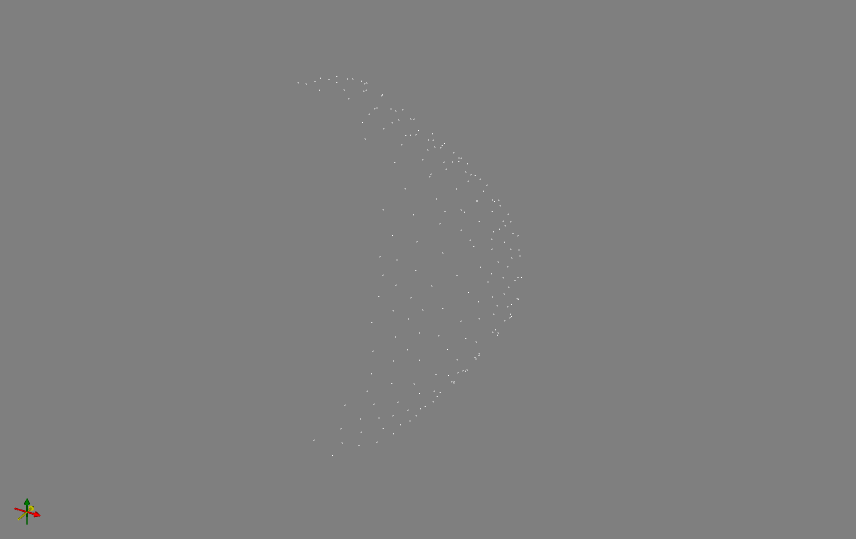
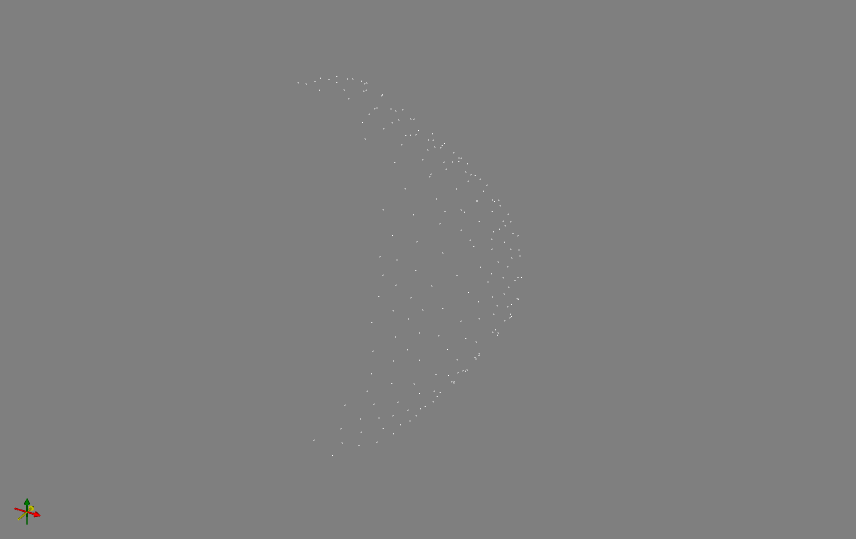

<IPython.core.display.Javascript object>

In [18]:
# View the STL data as a point cloud using itkWidgets, to verify the data was read correctly.

viewerA = view(point_sets=stl_polydata)

 ## 5.B. Convert STL to Labelmap

In [15]:
fg_image = itk.Image[itk.F,3].New()
fg_image.SetRegions(dicom_mr_image.GetLargestPossibleRegion())
fg_image.CopyInformation(dicom_mr_image)
fg_image.Allocate()
fg_image.FillBuffer(1)
fg_vtk_image = itk.vtk_image_from_image(fg_image)

# This creates a foreground image that defines the extent and template for rendering the STL data.

# The above command works because the dicom_mr_image has an identity matrix for its directions.
# Regretfully, vtk doesn't support images with non-identify acquisition directions, so be careful.

In [16]:
# polygonal data -> image stencil:
pol2stenc = vtk.vtkPolyDataToImageStencil()
pol2stenc.SetInputData(stl_polydata)
pol2stenc.SetOutputOrigin(dicom_mr_image.GetOrigin())
pol2stenc.SetOutputSpacing(dicom_mr_image.GetSpacing())
pol2stenc.SetOutputWholeExtent(fg_vtk_image.GetExtent())
pol2stenc.Update()

# image stencil -> image:
imgstenc = vtk.vtkImageStencil()
imgstenc.SetInputData(fg_vtk_image)
imgstenc.SetStencilConnection(pol2stenc.GetOutputPort())
imgstenc.ReverseStencilOff()
imgstenc.SetBackgroundValue(0)
imgstenc.Update()

stl_vtk_contour_image = imgstenc.GetOutput()

stl_contour_image = itk.image_from_vtk_image(stl_vtk_contour_image)


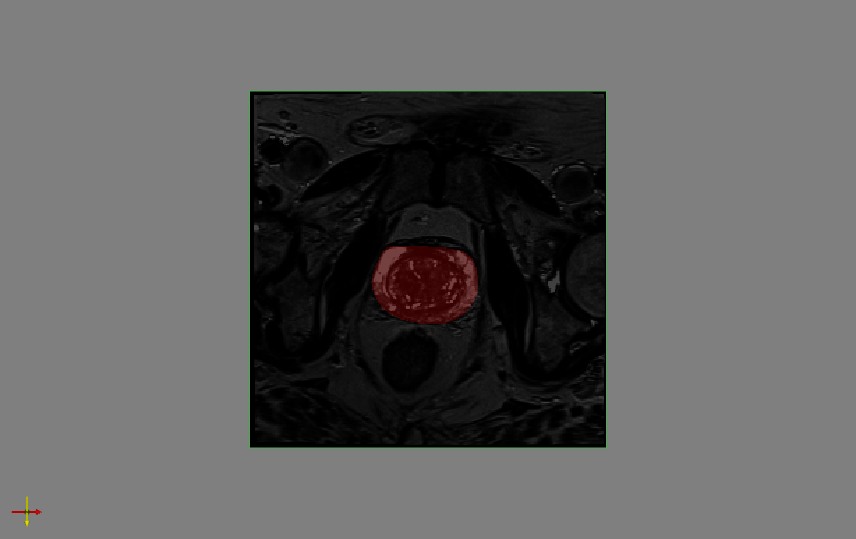
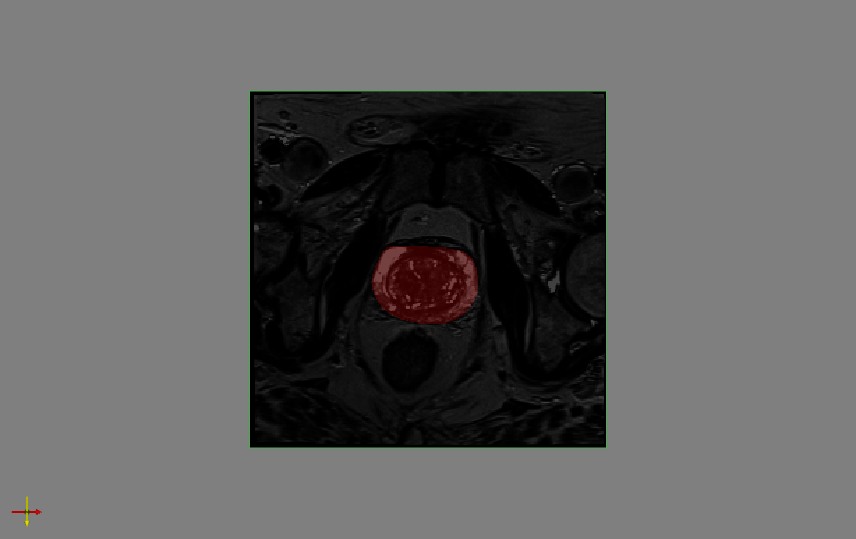

<IPython.core.display.Javascript object>

In [17]:
viewerB = view(image=dicom_mr_image, label_image=stl_contour_image)
viewerB.set_image_color_map("Grayscale")
viewerB.set_image_color_range([0,300])
viewerB.set_view_mode("ZPlane")
viewerB.set_ui_collapsed(False)

# Acknowledgements

TCIA is funded by the [Cancer Imaging Program (CIP)](https://imaging.cancer.gov/), a part of the United States [National Cancer Institute (NCI)](https://www.cancer.gov/), and is managed by the [Frederick National Laboratory for Cancer Research (FNLCR)](https://frederick.cancer.gov/).

If you leverage this notebook or any TCIA datasets in your work, please be sure to comply with the [TCIA Data Usage Policy](https://wiki.cancerimagingarchive.net/x/c4hF). In particular, make sure to cite the DOI(s) for the specific TCIA datasets you used in addition to TCIA citation provided below!

This notebook was created by [Stephen Aylward (Kitware)](https://www.kitware.com/stephen-aylward/), [Justin Kirby (Frederick National Laboratory for Cancer Research)](https://www.linkedin.com/in/justinkirby82/), [Brianna Major (Kitware)](https://www.kitware.com/brianna-major/), and [Matt McCormick (Kitware)](https://www.kitware.com/matt-mccormick/).   The creation of this notebook was funded, in part, by NIBIB and NIGMS R01EB021396, NIBIB R01EB014955, NCI R01CA220681, and NINDS R42NS086295.

If you have any questions, suggestions, or issues with itkWidgets, please post them on the [itkwidget issue tracker](https://github.com/InsightSoftwareConsortium/itkwidgets/issues) or feel free to email us at kitware@kitware.com.

## Data Citation
The data used in this notebook is part of the Prostate-MRI-US-Biopsy collection:

Natarajan, S., Priester, A., Margolis, D., Huang, J., & Marks, L. (2020). Prostate MRI and Ultrasound With Pathology and Coordinates of Tracked Biopsy (Prostate-MRI-US-Biopsy) [Data set]. The Cancer Imaging Archive. DOI: 10.7937/TCIA.2020.A61IOC1A

## Publication Citation
The data used in this notebook is part of the Prostate-MRI-US-Biopsy collection:

Sonn GA, Natarajan S, Margolis DJ, MacAiran M, Lieu P, Huang J, Dorey FJ, Marks LS. Targeted biopsy in the detection of prostate  cancer using an office based magnetic resonance ultrasound fusion device.  Journal of Urology 189, no. 1 (2013): 86-91. DOI: 10.1016/j.juro.2012.08.095

## TCIA Citation

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., & Prior, F. (2013). The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository. Journal of Digital Imaging, 26(6), 1045–1057. https://doi.org/10.1007/s10278-013-9622-7